<div style="padding:20px;color:#2b2d42;margin:0;font-size:180%;text-align:center;display:fill;border-radius:5px;background-color:white;overflow:hidden;font-weight:600">[Training-It's CORN] CNN-FastAI baseline</div>

<p style="text-align:center;"><img src="https://t3.ftcdn.net/jpg/03/80/84/16/360_F_380841637_ATRElxYXgDYBo8XOdzKJta2UIcvg6MW6.jpg" style="border-radius:5px" width="200" height="200"/></p>

<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: black; background-color: #ffffff;">Created by: Nghi Huynh</h5>

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">1. Imports</div>

In [1]:
!pip install torch-summary

In [2]:
import torch
from torchsummary import summary
from torch.autograd import Variable
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse
    
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import cv2
import gc
import random
from albumentations import *

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from fastai.metrics import error_rate, accuracy
from fastai.vision.all import *

import warnings
warnings.filterwarnings("ignore")

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">2. Configuration</div>

In [3]:
config = {
    'TRAIN_PATH': "../input/kaggle-pog-series-s01e03/corn/train",
    'TEST_PATH': "../input/kaggle-pog-series-s01e03/corn/test",
    'METADATA': "../input/kaggle-pog-series-s01e03/corn/train.csv",
    'fold': 0,
    'nfolds': 4,
    'resolution': (144,144),
    'NUM_WORKERS': 4,
    'bs': 64
}

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">3. Data preparation + CORN dataset</div>

**FastAI** [A Layered API for Deep Learning](https://arxiv.org/pdf/2002.04688.pdf)

<p style="text-align:center;"><img src="https://www.researchgate.net/publication/339348397/figure/fig1/AS:860122586820608@1582080613903/The-layered-API-from-fastai.ppm" style="border-radius:5px" width="400" height="400"/></p>

Let's create a CORN dataset to inherit the abstract class `Dataset` from Pytorch
* Train, Test split using [Stratified K-Fold](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) to deal with class imbalance. **StratifiedKFold to preserve the percentage of samples for each class**. If only use K-fold,  it assumes the class distribution of the target feature in the main data is 50:50, which leads to a biased estimate or overfitting in favor of the majority class.
* Resize on the fly to 144x144
* Normalize image to [0, 1]
* Encode label
* Return image, and a label as tensor

In [4]:
train_df = pd.read_csv(config['METADATA']).set_index('seed_id')
enc = LabelEncoder()
y = train_df.label.values
y_encoded = enc.fit_transform(y)
train_df['label_encoded'] = y_encoded
print("Label encoder classes:", list(enc.classes_))
train_df.head()

Label encoder classes: ['broken', 'discolored', 'pure', 'silkcut']


,view,image,label,label_encoded
seed_id,,,,
0,top,train/00000.png,broken,0
1,bottom,train/00001.png,pure,2
3,top,train/00003.png,broken,0
4,top,train/00004.png,pure,2
5,top,train/00005.png,discolored,1


In [5]:
def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1)) # since numpy array has [H,W,C] -> we want [C,H,W] for torch tensor
    return torch.from_numpy(img.astype(dtype, copy=False))

class CornDataset(Dataset):
    """Corn dataset
    
    Parameters
    ----------
    fold: int, default=0
    train_flag: boolean, default=True
    transform: transform function, default=None
    
    Attributes
    ----------
    fnames_: file names of training/val set
    train_flag_: flag if it's a train or validation set
    tfms_: transform function
    """
    def __init__(self, fold=config['fold'], train_flag=True, transform=None):
        # train-val split using Stratified K-Fold
        # split based on label
        ids = pd.read_csv(config['METADATA']).seed_id.astype(str).values
        # It is important to set random_state with shuffle=True
        # Otherwise, it will introduce data leakage later on
        # Refer to: https://www.kaggle.com/competitions/kaggle-pog-series-s01e03/discussion/357373#1971570 for detail explanation

        kf = StratifiedKFold(n_splits=config['nfolds'],shuffle=True, random_state=42)

        # list of indices for training and val set
        list_indices = list(kf.split(X=train_df,y=train_df['label']))
        ids = set(ids[list_indices[fold][0 if train_flag else 1]])
        fnames = []
        for fname in os.listdir(config['TRAIN_PATH']):
            if fname.split('.')[0].lstrip('0') in ids:
                fnames.append(fname)
                
        self.fnames = fnames
        self.train_flag = train_flag
        self.tfms = transform 
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        # Read img using cv2 require to convert to RGB color
        img = cv2.cvtColor(cv2.imread(os.path.join(config['TRAIN_PATH'], fname)), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, config['resolution'],
                         interpolation = cv2.INTER_AREA)
        label = train_df['label_encoded'][int(fname.split('.')[0].lstrip('0'))]
        if self.tfms is not None:
            augmented = self.tfms(image=img)
            img = augmented['image']
            
        return img2tensor((img/255.0)), label

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">4. Data Augmentation</div>

In [6]:
def get_transforms_train(p=1):
    transform_train = Compose([
        RandomRotate90(p=0.7),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0, scale_limit=(-0.2,0.2), rotate_limit=(-30,30), 
                         interpolation=1, border_mode=0, value=(0,0,0), p=0.5),
    ], p=p)
    return transform_train

In [7]:
ds = CornDataset(transform=get_transforms_train())
dl = DataLoader(ds, batch_size=64, shuffle=False,num_workers=config['NUM_WORKERS'])
imgs, labels = next(iter(dl))

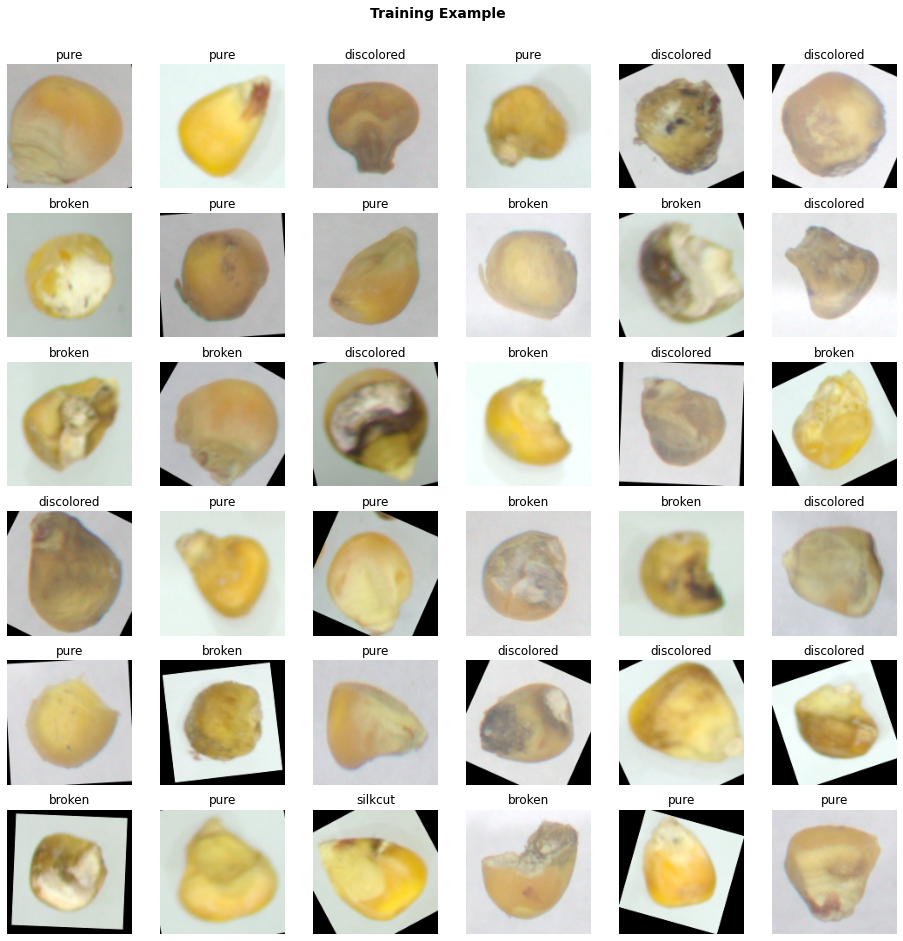

In [8]:
# show a batch of training example
plt.figure(figsize=(16,16))
for i,(img, label) in enumerate(zip(imgs[:36],labels[:36])):
    img = ((img.permute(1,2,0))*255.0).numpy().astype(np.uint8) # unnormalized
    plt.subplot(6,6,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    label_inverse = enc.inverse_transform([label]).item()
    plt.title(f'{label_inverse}')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
plt.suptitle('Training Example', y=0.93, weight="bold", size=14)
plt.show()
del ds, dl

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">5. Model architecture</div>

Let's create a simple CNN model with no pretrained weights: four convolutional layers defined with a 3×3 size kernels and two fully connected layers.

In [9]:
# Creating a CNN class
class CNN(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(69696, 128) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        
        # shape after conv and max_pool layer [B, n_out_channel, H, W]
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [10]:
model = CNN(4)

In [11]:
summary(model, imgs)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 142, 142]        896
├─Conv2d: 1-2                            [-1, 32, 140, 140]        9,248
├─MaxPool2d: 1-3                         [-1, 32, 70, 70]          --
├─Conv2d: 1-4                            [-1, 64, 68, 68]          18,496
├─Conv2d: 1-5                            [-1, 64, 66, 66]          36,928
├─MaxPool2d: 1-6                         [-1, 64, 33, 33]          --
├─Linear: 1-7                            [-1, 128]                 8,921,216
├─ReLU: 1-8                              [-1, 128]                 --
├─Linear: 1-9                            [-1, 4]                   516
Total params: 8,987,300
Trainable params: 8,987,300
Non-trainable params: 0
Total mult-adds (M): 452.79
Input size (MB): 15.19
Forward/backward pass size (MB): 14.09
Params size (MB): 34.28
Estimated Total Size (MB): 63.57


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 142, 142]        896
├─Conv2d: 1-2                            [-1, 32, 140, 140]        9,248
├─MaxPool2d: 1-3                         [-1, 32, 70, 70]          --
├─Conv2d: 1-4                            [-1, 64, 68, 68]          18,496
├─Conv2d: 1-5                            [-1, 64, 66, 66]          36,928
├─MaxPool2d: 1-6                         [-1, 64, 33, 33]          --
├─Linear: 1-7                            [-1, 128]                 8,921,216
├─ReLU: 1-8                              [-1, 128]                 --
├─Linear: 1-9                            [-1, 4]                   516
Total params: 8,987,300
Trainable params: 8,987,300
Non-trainable params: 0
Total mult-adds (M): 452.79
Input size (MB): 15.19
Forward/backward pass size (MB): 14.09
Params size (MB): 34.28
Estimated Total Size (MB): 63.57

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">6. Loss and metric</div>

* Loss: softmax cross entropy loss since this is multi-class classification
* Metrics: accuracy

In [12]:
def xloss(logits, labels, ignore=None, reduction='mean'):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), reduction=reduction)

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">7. Training</div>

Let's set up the fastai training pipeline.

Steps to train our model from scratch:
1. Create your `DataLoader` using `ImageDataLoader` from `fast.ai`: to generate batches of images to feed into your model
2. Create a `Learner` to handle training. Some core parameters in this `Learner` are:
* dls: `DataLoader`
* model: our defined model
* loss_func: loss function for training. We can use `fastai` loss functions or you can customize your own loss function
* opt_func: optimization function for training. The default `opt_func` is `Adam`. You can also customize your `opt_func` 
* metrics: to evaluate the performance of our model. It accepts function, list of functions or `Metrics` class. You can customize it following this [blueprint `Metric`](https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle)
3. `Learner.unfreeze()`: to set all layers to be trainable (`required_grad=True` so the model can update the weights based on the loss function. It's a good practice to unfreeze all the layers when you want to train from scratch.
3. `Learner.fit_one_cycle()`: is a learning-rate scheduler. It uses *[one-cycle policy](https://docs.fast.ai/learner.html#metric)* to schedule the learning rate using cosine annealing. 

### DataLoader and Learner

In [35]:
model = CNN(4).cuda()

In [36]:
ds_t = CornDataset(fold=config['fold'], train_flag=True, transform=get_transforms_train()) 
ds_v = CornDataset(fold=config['fold'], train_flag=False)
data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=config['bs'],
                                   num_workers=0,pin_memory=True)

In [37]:
learn = Learner(data, model, loss_func=xloss,
                metrics=[accuracy, error_rate]).to_fp16() 

### Let's check what we have in our `Learner`. 

In [16]:
learn.summary()

CNN (Input shape: 64 x 3 x 144 x 144)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 142 x 142 
Conv2d                                    896        True      
____________________________________________________________________________
                     64 x 32 x 140 x 140 
Conv2d                                    9248       True      
____________________________________________________________________________
                     64 x 32 x 70 x 70   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 68 x 68   
Conv2d                                    18496      True      
____________________________________________________________________________
                     64 x 64 x 66 x 66   
Conv2d                                    36928      True      
____________________________________________________________

You can see that all layers are trainable at this moment, which means the model will update the weights all the way to the very first layer. However, this is not the case if we want to use transfer learning. Refer to this discussion in the fastai forum for more detail: "[Why do we need to unfreeze the learner everytime before retarining even if learn.fit_one_cycle() works fine without learn.unfreeze()?](https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614)"

Besides the default Callbacks (cbs), we will also add `CSVLogger` to store the history of our training loop, and `SaveModelCallBack` to save the best model for all the epochs. 

Now, let's train our CNN model for 10 epochs!

In [38]:
learn.unfreeze()                                                                                                                                                                                                                                                                                                                                                                                                               
learn.fit_one_cycle(20, lr_max=slice(1e-4, 1e-3),
                    cbs=[CSVLogger(append=False), SaveModelCallback(monitor='accuracy',comp=np.greater)])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.164828,1.105984,0.507542,0.492458,00:53
1,1.171311,1.136564,0.478212,0.521788,00:54
2,1.122898,1.071519,0.525698,0.474302,00:53
3,1.099761,1.081353,0.515084,0.484916,00:54
4,1.088884,1.049937,0.538547,0.461453,00:54
5,1.045390,1.026664,0.539106,0.460894,00:54
6,1.003986,0.964968,0.564804,0.435196,00:53
7,0.966679,0.913589,0.600838,0.399162,00:53
8,0.939214,0.904496,0.603073,0.396927,00:53
9,0.916884,0.899909,0.606983,0.393017,00:53


Better model found at epoch 0 with accuracy value: 0.5075418949127197.
Better model found at epoch 2 with accuracy value: 0.5256983041763306.
Better model found at epoch 4 with accuracy value: 0.5385474562644958.
Better model found at epoch 5 with accuracy value: 0.5391061305999756.
Better model found at epoch 6 with accuracy value: 0.5648044943809509.
Better model found at epoch 7 with accuracy value: 0.6008380055427551.
Better model found at epoch 8 with accuracy value: 0.6030726432800293.
Better model found at epoch 9 with accuracy value: 0.6069832444190979.


In [39]:
gc.collect()
torch.cuda.empty_cache()

You can use this `torch.save(learn.model.state_dict(),f'model_0.pth')` to manually save your model. However, it will only save the model from the last epoch.

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">8. Model performance</div>

## Visualize model loss and accuracy

In [40]:
history = pd.read_csv('./history.csv')

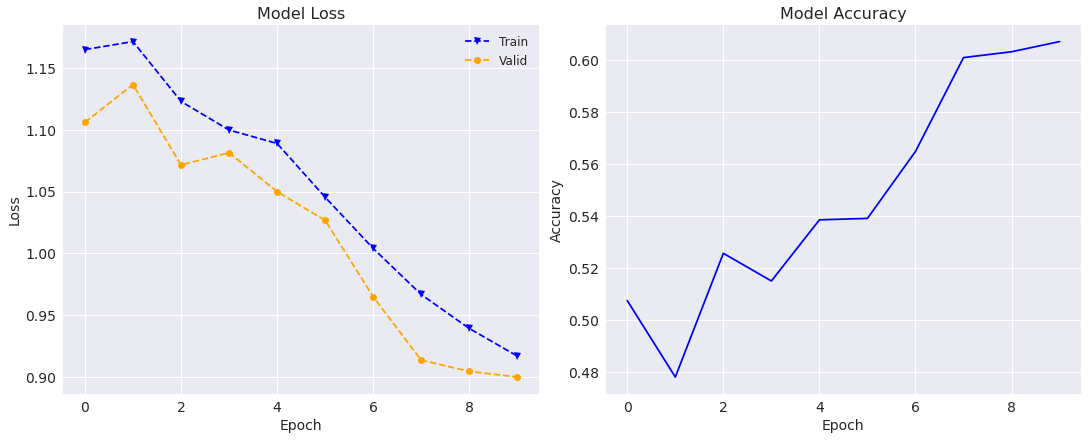

In [41]:
plt.style.use('seaborn')
fig1 = plt.figure(figsize=(15,6), constrained_layout=True)
axs = fig1.subplots(1,2)
axs[0].plot(history.epoch.values, history.train_loss.values, color='blue',\
            marker='v', linestyle='--', label='Train'
           )
axs[0].plot(history.epoch.values, history.valid_loss.values, label='Valid',\
            color='orange', marker='o', linestyle='--')
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_ylabel('Loss', size=14)
axs[0].set_xticks(np.arange(0,10,2))
axs[0].set_title('Model Loss', size=16)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontsize(14)
axs[0].legend(fontsize=12)

axs[1].plot(history.epoch.values, history.accuracy.values, color='blue')
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_ylabel('Accuracy', size=14)
axs[1].set_title('Model Accuracy', size=16)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontsize(14)


plt.show()

### Observations

* Train loss and valid loss decrease, while accuracy increases over epochs -> good sign that our model is capable of learning something
* Valid loss is smaller than train loss -> valid samples might be easier to predict than training samples

## Confusion matrix

In [42]:
dl_val = DataLoader(ds_v, bs=64, shuffle=False,num_workers=config['NUM_WORKERS'])
imgs, labels = next(iter(dl_val))

In [43]:
# Load pretrained model
path = './models/model.pth'
state_dict = torch.load(path, map_location=torch.device('cpu'))
model = CNN(num_classes=4)
model.load_state_dict(state_dict)
model.float()
model.eval()
model.cuda()

CNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=69696, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [44]:
# make prediction on val set
with torch.no_grad():
    preds = model(imgs.cuda())
    preds = torch.argmax(torch.softmax(preds, dim=1).cpu(), dim=1).numpy()

In [45]:
cm = confusion_matrix(labels.numpy(), preds, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=enc.classes_)

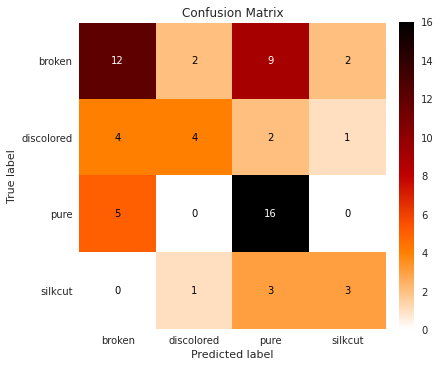

In [46]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='gist_heat_r', ax=ax)
# Get the images on an axis
im = ax.images
# Assume colorbar was plotted last one plotted last
cb = im[-1].colorbar
mappable = cb.mappable
cb.remove()
# Plot new colorbar to fit with the confusion matrix
plt.colorbar(mappable, fraction=0.046, pad=0.04)
ax.set(title='Confusion Matrix')
plt.show()

In [47]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.57      0.48      0.52        25
           1       0.57      0.36      0.44        11
           2       0.53      0.76      0.63        21
           3       0.50      0.43      0.46         7

    accuracy                           0.55        64
   macro avg       0.54      0.51      0.51        64
weighted avg       0.55      0.55      0.54        64



### Observations
Personally, I find myself getting confused whenever I look at the confusion matrix. Thus, I rely on the classification report to draw most of my decision in selecting which model to keep. 

First, let's recall the [distribution of those categories](https://www.kaggle.com/competitions/kaggle-pog-series-s01e03/discussion/355116):

* pure: 0.43247
* broken: 0.30316
* discolored: 0.16522
* silkcut: 0.09915

Now, let's look at the classification report. We can observe that `pure` is the label with the highest f1 score, 72%(harmonic mean between precision and recall), whereas `silkcut` is the label with the lowest f1 score, 22%. Since `pure` also has the highest distribution, while `silkcut` has the lowest distribution in the training set, the model might have picked the patterns of `pure` corns more often than other categories. Thus, the model classifies it more correctly than other categories. 

Even though the public test set has a similar distribution to the training set (thanks to [@miwojc probing discussion](https://www.kaggle.com/competitions/kaggle-pog-series-s01e03/discussion/355116)), we might want to select a model with a more balanced distribution in the f1-score in all categories to submit. 

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#f9c74f;overflow:hidden">9. References</div>

* **FastAI** [A Layered API for Deep Learning](https://arxiv.org/pdf/2002.04688.pdf)
* "[Why do we need to unfreeze the learner everytime before retarining even if learn.fit_one_cycle() works fine without learn.unfreeze()?](https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614)"

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:5px;background-color:#adc178;overflow:hidden">Have Fun!</div>